#  Problem Statement 
- Menentukan perbandingkan persentase mobilitas masyarakat Indonesia di Jakarta antara tahun 2020 dan tahun 2021
- Menentukan perbandingkan jumlah terkonfirmasi covid antara tahun 2020 dan tahun 2021 serta pengaruhnya terhadap mobilitas masyarakat khususnya retail dan rekreasi serta tempat kerja
- Menentukan korelasi antara tingkat kenaikan / penurunan covid 19 dengan data vaksin masyarakat
- Menentukan korelasi covid 19 terhadap ekonomi masyarakat disertai dengan data pendukung
- Menentukan perbandingan antara kasus positif, sembuh, dan meninggal

# Data Cleaning and Preprocessing


### Mengimpor dan Membersihkan Data

In [2]:
# Importing pandas and raw DataFrame
import pandas as pd

agg_jkt = pd.read_excel('Daily Update Data Agregat Covid-19 Jakarta.xlsx')
vacc_jktraw = pd.read_excel('Daily Update Data Agregat Covid-19 Jakarta.xlsx', sheet_name='Daily Vaksinasi Wilayah')
df1 = pd.read_csv('2020_ID_Region_Mobility_Report.csv')
df2 = pd.read_csv('2021_ID_Region_Mobility_Report.csv')
df3 = pd.read_csv('2022_ID_Region_Mobility_Report.csv')

# Merging mobility DataFrame
mobility = [df1, df2, df3]
mobility_jkt = pd.concat(mobility)

# Data cleaning
mobility_jkt = mobility_jkt.dropna(subset=['sub_region_1'])
mobility_jkt = mobility_jkt.loc[mobility_jkt['sub_region_1'] == 'Jakarta']
mobility_jkt = mobility_jkt[['country_region','sub_region_1','date','retail_and_recreation_percent_change_from_baseline','workplaces_percent_change_from_baseline']]

vacc_jktraw = vacc_jktraw[['Tanggal','Cakupan Suntik 1','Cakupan Suntik 2']]
vacc_jktraw = vacc_jktraw.dropna()

# Filling NA data with zeroes and dropping unused column
agg_jkt.update(agg_jkt[['Tanpa Gejala','Bergejala','Belum Ada Data']].fillna(0))
agg_jkt.drop(['Jam','Tanggal Jam'],axis=1,inplace=True)

# Slicing to certain period of time (since: 2020-03-01 until: 2022-06-27)
agg_jkt = agg_jkt[~(agg_jkt['Tanggal'] > '2022-06-27')]
vacc_jktraw = vacc_jktraw[~(vacc_jktraw['Tanggal'] > '2022-06-27')]
mobility_jkt = mobility_jkt[~((mobility_jkt['date'] < '2020-03-01')) & ~(mobility_jkt['date'] > '2022-06-27')]


In [3]:
# Adding new columns for Jakarta Covid Data Agregate and Vaccine Data
agg_jkt['Meninggal Harian'] = agg_jkt['Meninggal'] - agg_jkt['Meninggal'].shift(1)
agg_jkt.at[0,'Meninggal Harian'] = 0

vacc_jktraw['Akumulasi Vaksin 1'] = vacc_jktraw['Cakupan Suntik 1'].cumsum()
vacc_jktraw['Akumulasi Vaksin 2'] = vacc_jktraw['Cakupan Suntik 2'].cumsum()
vacc_jktraw.at[0,'Akumulasi Vaksin 1'] = vacc_jktraw.iat[0,1]
vacc_jktraw.at[0,'Akumulasi Vaksin 2'] = vacc_jktraw.iat[0,2]

# Extending vaccine data to 2020-03-01
from datetime import datetime
frames = pd.date_range(start="2020-03-01",end="2021-06-11").to_pydatetime().tolist(); tanggal = []
for date in frames: tanggal += [[date.strftime('%Y/%m/%d')]]
nambah_df = pd.DataFrame(frames)
nambah_df['Cakupan Suntik 1']=nambah_df['Cakupan Suntik 2']=nambah_df['Akumulasi Vaksin 1']=nambah_df['Akumulasi Vaksin 2']=0
nambah_df = nambah_df.rename(columns={0:'Tanggal',1:'Cakupan Suntik 1',2:'Cakupan Suntik 2'})
frames = [nambah_df, vacc_jktraw]
vacc_jkt = pd.concat(frames)
vacc_jkt = vacc_jkt.reset_index()

### Menampilkan Semua DataFrame yang Digunakan

##### 1. Data Agregat Jakarta

In [4]:
agg_jkt

,Tanggal,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data,Meninggal Harian
0,2020-03-01,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,2020-03-02,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2020-03-03,1,0,0,2,3,3,2,0,0.0,0.0,0.0,1.0
3,2020-03-04,1,0,0,2,3,0,2,0,0.0,0.0,0.0,0.0
4,2020-03-05,3,0,0,4,7,4,4,0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-06-23,15311,1239359,6714,514,1261898,1054,7228,605,0.0,34.0,7194.0,0.0
845,2022-06-24,15313,1240028,7301,522,1263164,1266,7823,669,0.0,56.0,7767.0,2.0
846,2022-06-25,15313,1240738,7596,562,1264209,1045,8158,710,0.0,43.0,8115.0,0.0
847,2022-06-26,15313,1241429,7931,591,1265264,1055,8522,691,0.0,41.0,8481.0,0.0


##### 2. Data Vaksin Jakarta

In [5]:
vacc_jkt

,index,Tanggal,Cakupan Suntik 1,Cakupan Suntik 2,Akumulasi Vaksin 1,Akumulasi Vaksin 2
0,0,2020-03-01,0.0,0.0,0.0,0.000
1,1,2020-03-02,0.0,0.0,0.0,0.000
2,2,2020-03-03,0.0,0.0,0.0,0.000
3,3,2020-03-04,0.0,0.0,0.0,0.000
4,4,2020-03-05,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...
844,376,2022-06-23,982.0,2281.0,8602081.0,8216350.023
845,377,2022-06-24,1213.0,767.0,8603294.0,8217117.023
846,378,2022-06-25,537.0,1553.0,8603831.0,8218670.023
847,379,2022-06-26,311.0,553.0,8604142.0,8219223.023


##### 3. Data Mobilisasi Jakarta

In [6]:
mobility_jkt

,country_region,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,workplaces_percent_change_from_baseline
4188,Indonesia,Jakarta,2020-03-01,4.0,6
4189,Indonesia,Jakarta,2020-03-02,6.0,6
4190,Indonesia,Jakarta,2020-03-03,3.0,5
4191,Indonesia,Jakarta,2020-03-04,-2.0,4
4192,Indonesia,Jakarta,2020-03-05,3.0,5
...,...,...,...,...,...
2487,Indonesia,Jakarta,2022-06-23,-12.0,-14
2488,Indonesia,Jakarta,2022-06-24,-7.0,-14
2489,Indonesia,Jakarta,2022-06-25,-9.0,-5
2490,Indonesia,Jakarta,2022-06-26,-9.0,0


# Exploratory Data Analysis

### Tipe Data pada DataFrame yang Digunakan


##### 1. Data Agregat Jakarta

In [7]:
# Obtaining data types in each column 
agg_jkt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 849 entries, 0 to 848
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Tanggal           849 non-null    datetime64[ns]
 1   Meninggal         849 non-null    int64         
 2   Sembuh            849 non-null    int64         
 3   Self Isolation    849 non-null    int64         
 4   Masih Perawatan   849 non-null    int64         
 5   Total Pasien      849 non-null    int64         
 6   Positif Harian    849 non-null    int64         
 7   Positif Aktif     849 non-null    int64         
 8   Sembuh Harian     849 non-null    int64         
 9   Tanpa Gejala      849 non-null    float64       
 10  Bergejala         849 non-null    float64       
 11  Belum Ada Data    849 non-null    float64       
 12  Meninggal Harian  849 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 125.1 KB


##### 2. Data Vaksinasi Jakarta

In [8]:
vacc_jkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               849 non-null    int64         
 1   Tanggal             849 non-null    datetime64[ns]
 2   Cakupan Suntik 1    849 non-null    float64       
 3   Cakupan Suntik 2    849 non-null    float64       
 4   Akumulasi Vaksin 1  849 non-null    float64       
 5   Akumulasi Vaksin 2  849 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 39.9 KB


##### 3. Data Mobilisasi Jakarta

In [9]:
mobility_jkt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 849 entries, 4188 to 2491
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   country_region                                      849 non-null    object 
 1   sub_region_1                                        849 non-null    object 
 2   date                                                849 non-null    object 
 3   retail_and_recreation_percent_change_from_baseline  849 non-null    float64
 4   workplaces_percent_change_from_baseline             849 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 39.8+ KB


Data terdiri dari sebanyak 849 hari observasi dengan jumlah kasus diperbaharui tiap harinya dengan periode waktu sampel 1 Maret 2020 sampai dengan 27 Juli 2022

### Statistik Data pada DataFrame

##### 1. Data Agregat Jakarta

In [10]:
# Obtaining the statistical summary of the data
agg_jkt.describe()

,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data,Meninggal Harian
count,849.000000,8.490000e+02,849.000000,849.000000,8.490000e+02,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000
mean,7592.875147,4.963158e+05,9086.696113,3439.687868,5.164351e+05,1491.286219,12526.383981,1463.234393,3044.545347,4124.678445,6431.996466,18.036514
std,5769.714818,4.364342e+05,15156.047878,4760.298023,4.442303e+05,2527.893428,19509.345880,2749.855152,5702.169058,7438.846967,14214.370088,27.969404
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1718.000000,5.886500e+04,1323.000000,506.000000,7.330900e+04,131.000000,2283.000000,122.000000,0.000000,0.000000,490.000000,2.000000
50%,6710.000000,3.944030e+05,4201.000000,2196.000000,4.078310e+05,659.000000,7027.000000,606.000000,59.000000,84.000000,1386.000000,11.000000
75%,13576.000000,8.497790e+05,8720.000000,3974.000000,8.638110e+05,1425.000000,12590.000000,1300.000000,3935.000000,5831.000000,4938.000000,22.000000
max,15313.000000,1.242286e+06,88295.000000,30418.000000,1.266102e+06,15825.000000,113138.000000,20570.000000,35311.000000,60476.000000,88873.000000,265.000000


Selama periode 1 Maret 2020 hingga 27 Juni 2022, kasus COVID positif harian tertinggi berada pada sejumlah 15.825 kasus dengan rata-rata kasus hariannya 1.491 kasus. Jumlah pasien meninggal tertinggi dalam satu hari yakni sejumlah 265, dengan jumlah meninggal rata-rata tiap harinya sebanyak 18 jiwa per hari. Di samping itu jumlah pasien sembuh dari COVID terbanyak terjadi ejumlah 20.570 pasien, dengan jumlah kesembuhan rata-rata 1.463 pasien per harinya.

In [11]:
# Death to recovered percentage
100 * agg_jkt['Meninggal Harian'] / agg_jkt['Sembuh Harian'].mean()

0      0.000000
1      0.000000
2      0.068342
3      0.000000
4      0.136684
         ...   
844    0.000000
845    0.136684
846    0.000000
847    0.000000
848    0.000000
Name: Meninggal Harian, Length: 849, dtype: float64

Persentase jumlah pasien meninggal dan kesembuhan pasien rata-rata tiap harinya adalah 1.23%

##### 2. Data Vaksinasi Jakarta

In [12]:
vacc_jktraw.describe()

,Cakupan Suntik 1,Cakupan Suntik 2,Akumulasi Vaksin 1,Akumulasi Vaksin 2
count,381.000000,381.000000,3.810000e+02,3.810000e+02
mean,22586.569554,21574.892449,6.956000e+06,5.728575e+06
std,37383.978520,34755.656436,2.143375e+06,2.714745e+06
min,0.000000,0.000000,1.928100e+04,1.173000e+03
25%,1347.000000,1423.000000,6.579185e+06,4.829470e+06
50%,5697.000000,5912.000000,7.543504e+06,6.644367e+06
75%,25281.000000,24483.000000,8.437159e+06,8.006979e+06
max,293767.000000,227024.000000,8.605483e+06,8.220034e+06


Berdasarkan data ini, total jumlah penduduk Jakarta yang telah divaksin dosis pertama adalah sebanyak 404.526 orang. Sedangkan, jumlah penduduk Jakarta yang telah divaksin dosis kedua adalah sebanyak 342.892 orang (data per 27 Juni 2022)

##### 3. Data Mobilisasi Jakarta

In [13]:
mobility_jkt.describe()

,retail_and_recreation_percent_change_from_baseline,workplaces_percent_change_from_baseline
count,849.000000,849.000000
mean,-26.186101,-27.914016
std,14.075546,15.199100
min,-68.000000,-82.000000
25%,-34.000000,-35.000000
50%,-26.000000,-29.000000
75%,-16.000000,-16.000000
max,10.000000,8.000000


Semenjak pandemi terjadi, terjadi penurunan yang sangat besar pada mobilisasi warga terutama pada sektor pekerjaan yang turun hingga 82% dari biasanya dan sektor ritel & rekreasi yang turun hingga 68%. Kedua sektor retail & rekreasi dan pekerjaan ini berturut-turut mengalami penurunan rata-rata sebesar 26.2% dan 27.9%. Hal ini menunjukkan bahwa pandemi sangat menghambat mobilitas warga.

### Analisis Data

#### Lonjakan kasus positif Corona tertinggi

In [14]:
# Obtaining data with the highest daily daily positive case
agg_jkt.loc[agg_jkt['Positif Harian'].idxmax()]

Tanggal             2022-02-06 00:00:00
Meninggal                         13794
Sembuh                           899957
Self Isolation                    52594
Masih Perawatan                   14625
Total Pasien                     980970
Positif Harian                    15825
Positif Aktif                     67219
Sembuh Harian                      8386
Tanpa Gejala                       45.0
Bergejala                           6.0
Belum Ada Data                  67168.0
Meninggal Harian                   27.0
Name: 707, dtype: object

In [15]:
mobility_jkt.loc[mobility_jkt['date'] == '2022-02-06']

,country_region,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,workplaces_percent_change_from_baseline
2350,Indonesia,Jakarta,2022-02-06,-18.0,-7


Jumlah kasus positif harian terbanyak terjadi pada tanggal 6 Februari 2022. Hal ini mungkin dapat terjadi karena adanya varian baru corona yang masuk ke Indonesia yakni varian Omicron. Selain itu, pada masa ini juga sudah tidak diberlakukan lagi pembatasan sosial sehingga persebaran virus corona semakin bebas. Hal ini semakin didukung oleh adanya cuti bersama pada taun baru sehingga meningkatnya mobilitas warga yang di atas rata-rata selama pandemi.

#### Analisis Triwulan

In [ ]:
jkt_feb_may_20 = agg_jkt.loc[(agg_jkt['Tanggal'] >= '2020-02-01') & (agg_jkt['Tanggal'] <= '2020-05-01')].mean()
jkt_may_aug_20 = agg_jkt.loc[(agg_jkt['Tanggal'] >= '2020-05-01') & (agg_jkt['Tanggal'] <= '2020-08-01')].mean()
jkt_aug_nov_20 = agg_jkt.loc[(agg_jkt['Tanggal'] >= '2020-08-01') & (agg_jkt['Tanggal'] <= '2020-11-01')].mean()
jkt_nov20_feb_21 = agg_jkt.loc[(agg_jkt['Tanggal'] >= '2020-11-01') & (agg_jkt['Tanggal'] <= '2021-02-01')].mean()

Kami membagi data per tiga bulan untuk melihat tren kenaikan / penurunan covid melalui rata - rata data triwulan

In [17]:
triwulan = pd.DataFrame({'Atribute':jkt_feb_may_20[['Positif Harian','Sembuh Harian','Meninggal Harian']].index, 'Feb20-May20':jkt_feb_may_20[['Positif Harian','Sembuh Harian','Meninggal Harian']].values, 'May20-Aug20':jkt_may_aug_20[['Positif Harian','Sembuh Harian','Meninggal Harian']].values, 'Aug20-Nov20':jkt_aug_nov_20[['Positif Harian','Sembuh Harian','Meninggal Harian']].values, 'Nov20-Feb21':jkt_nov20_feb_21[['Positif Harian','Sembuh Harian','Meninggal Harian']].values})
triwulan


,Atribute,Feb20-May20,May20-Aug20,Aug20-Nov20,Nov20-Feb21
0,Positif Harian,69.080645,187.494624,914.021505,1803.602151
1,Sembuh Harian,6.887097,144.892473,877.537634,1610.408602
2,Meninggal Harian,6.338710,5.064516,15.451613,22.387097


Berdasarkan data triwulan di atas tren covid 19 selalu mengalami kenaikan salah satunya dapat dilihat dari data positif harian

# Modelling

In [18]:
# Configuring plot size
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

<AxesSubplot:xlabel='Atribute'>

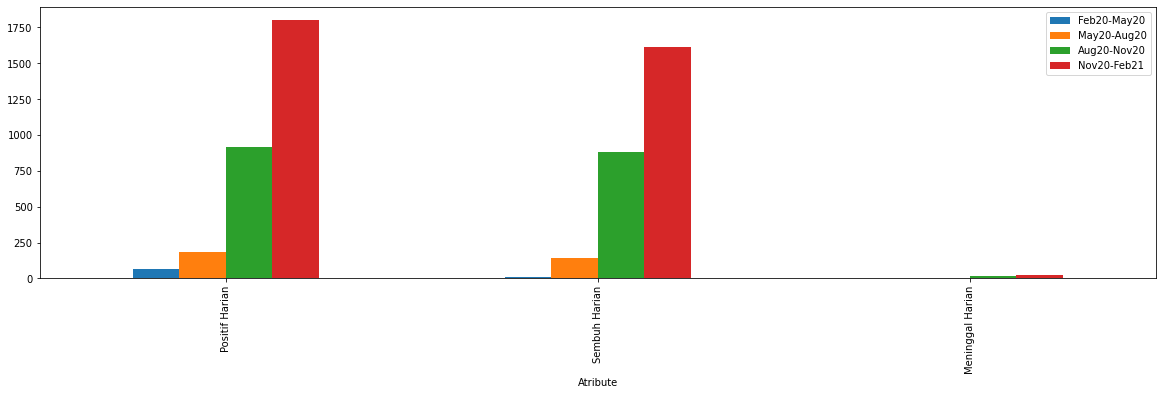

In [19]:

triwulan.plot(kind='bar',x='Atribute',y=['Feb20-May20','May20-Aug20','Aug20-Nov20','Nov20-Feb21'])

Data di atas merupakan perbandingan antara kasus positif harian, sembuh harian, dan meninggal harian pada triwulan yang diambil pada periode Februari 2020 sampai Februari 2021. Dari setiap triwulan setiap kasus terus meningkat.

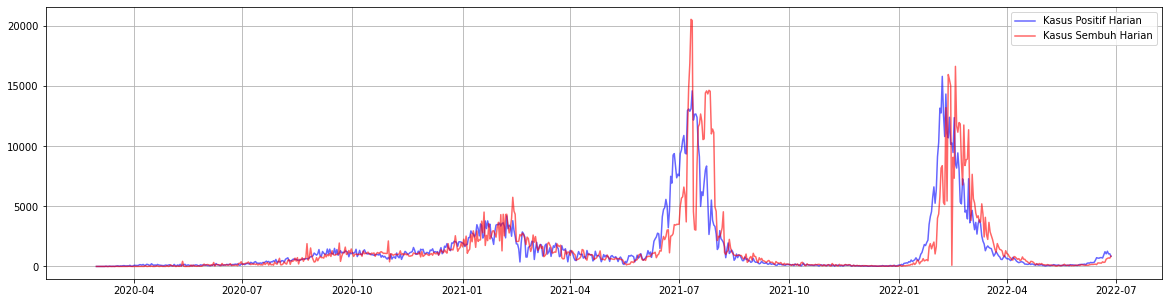

In [20]:
# Plotting daily positive, deaths, and recovered case

# Plotting the same x-axis to both data
x = agg_jkt['Tanggal']

# Plotting data in each of its axis
plt.plot(x,agg_jkt['Positif Harian'],color='blue',label='Kasus Positif Harian', alpha = 0.6)
plt.plot(x,agg_jkt['Sembuh Harian'],color='red',label='Kasus Sembuh Harian', alpha = 0.6)

# Adding legends and grid
plt.legend()
plt.grid('on')

# Showing the graphplt.style.use('seaborn-white')
plt.show()

Pada model grafik di atas terlihat perbandingan antara kasus positif harian dan kasus sembuh harian. Kasus sembuh harian terlihat lebih tinggi daripada kasus positif harian, hal ini karena gencarnya program vaksinasi covid dan sadarnya masyarakat akan pentingnya vaksinasi.

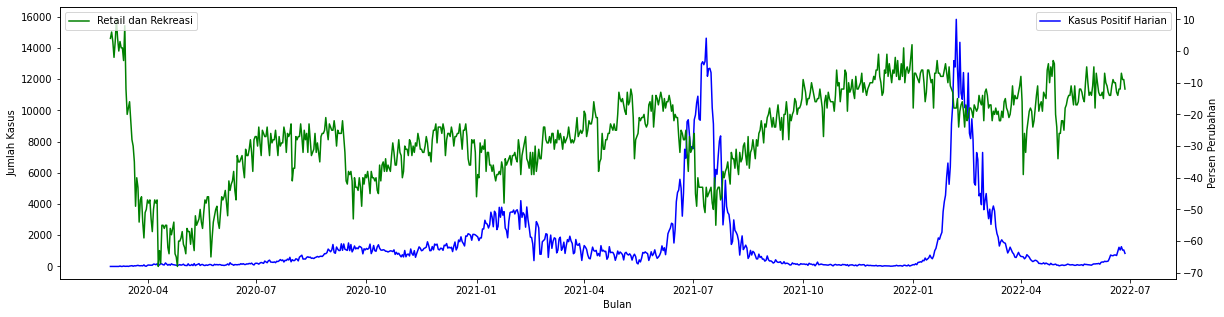

In [21]:
#Plotting daily positive case and mobility data of retail and recreation
fig, ax1 = plt.subplots()

x = agg_jkt['Tanggal']

# Plotting the same x-axis to both data
ax2 = ax1.twinx()

# Plotting data in each of its axes
ax1.plot(x,agg_jkt['Positif Harian'],color='blue',label='Kasus Positif Harian')
ax2.plot(x,mobility_jkt['retail_and_recreation_percent_change_from_baseline'],color='green',label='Retail dan Rekreasi')

# Naming axes labels
ax1.set_xlabel('Bulan')
ax1.set_ylabel('Jumlah Kasus')
ax2.set_ylabel('Persen Perubahan')

# Adding legends
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')

# Showing the graph
plt.show() 

Pada model grafik di atas terlihat perbandingan antara data kasus positif harian yang ditandai dengan garis berwarna biru dengan persentase mobilitas di bidang retail dan rekreasi yang ditandai dengan garis berwarna hijau. Meningkatnya kasus positif berbanding lurus dengan penurunan mobilitas di bidang retail dan rekreasi. Penurunan yang terlihat signifikan terdapat pada model grafik pada Juli 2021. Hal ini berkaitan dengan diberlakukannya PPKM level 4 untuk Jawa Bali dan PPKM level 3 di luar Jawa Bali.

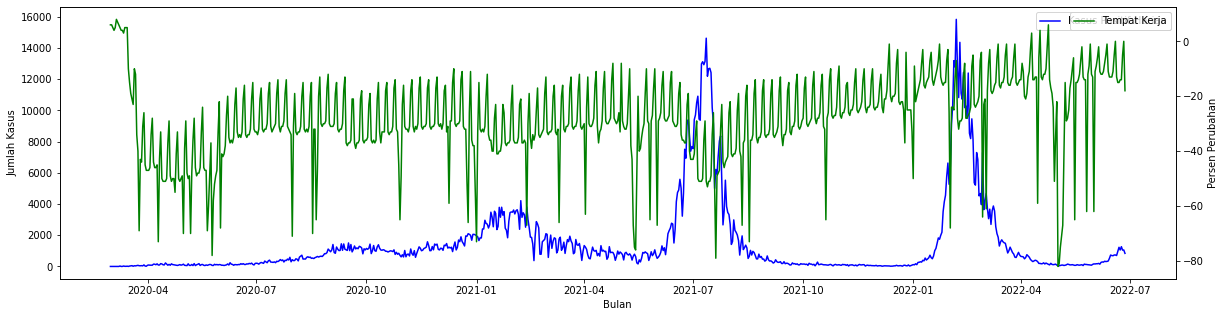

In [22]:
# Plotting daily positive case and mobility data of workplaces
fig, ax1 = plt.subplots()
x = agg_jkt['Tanggal']

# Plotting the same x-axis to both data
ax2 = ax1.twinx()

# Plotting data in each of its axes
ax1.plot(x,agg_jkt['Positif Harian'],color='blue',label='Kasus Positif Harian')
ax2.plot(x,mobility_jkt['workplaces_percent_change_from_baseline'],color='green',label='Tempat Kerja')

# Naming axes labels
ax1.set_xlabel('Bulan')
ax1.set_ylabel('Jumlah Kasus')
ax2.set_ylabel('Persen Perubahan')

# Adding legends
ax1.legend()
ax2.legend()

# Showing the gph
plt.show()

Pada model grafik di atas terlihat perbandingan antara data kasus positif harian yang ditandai dengan garis berwarna biru dengan persentase mobilitas di tempat kerja yang ditandai dengan garis berwarna hijau. Seperti bidang retail dan rekreasi kasus positif yang meningkat juga berpengaruh terhadap mobilitas di tempat kerja, contohnya pada saat kasus covid sedang tinggi yaitu pada Juli 2021 serta rentang antara Januari 2022 dan April 2022 persentase mobilitas tempat kerja menurun signifikan.

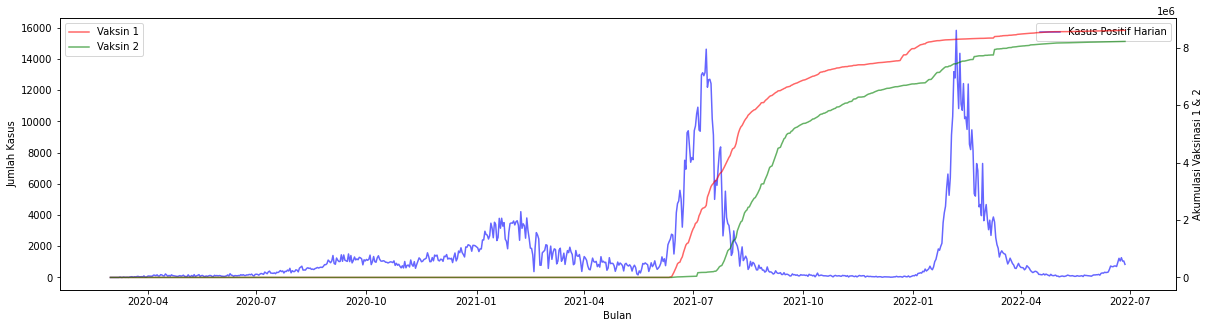

In [23]:
#Plotting daily positive case and accumulated vaccine data
fig, ax1 = plt.subplots()

x = agg_jkt['Tanggal']

# Plotting the same x-axis to both data
ax3 = ax2 = ax1.twinx()

# Plotting data in each of its axes
ax1.plot(x,agg_jkt['Positif Harian'],color='blue',label='Kasus Positif Harian', alpha = 0.6)
ax2.plot(x,vacc_jkt['Akumulasi Vaksin 1'],color='red',label='Vaksin 1', alpha = 0.6)
ax2.plot(x,vacc_jkt['Akumulasi Vaksin 2'],color='green',label='Vaksin 2', alpha = 0.6)

# Naming axes labels
ax1.set_xlabel('Bulan')
ax1.set_ylabel('Jumlah Kasus')
ax2.set_ylabel('Akumulasi Vaksinasi 1 & 2')

# Adding legends
ax1.legend()
ax2.legend()
ax3.legend()

# Showing the graph
plt.show()

Ketika vaksin mulai di gencarkan kepada masyarakat, grafik covid 19 pun menurun dengan signifikan seperti yang ditunjukkan pada grafik antara Juli 2021 dan Oktober 2021. Sebaliknya, ketika kegiatan vaksinasi mulai melonggar grafik covid mengalami kenaikan seperti yang ditunjukkan pada grafik antara Januari 2022 dan April 2022. Terdapat keterangan yang menunjukkan akumulasi vaksinasi 1 dan 2 di bagian kanan grafik.

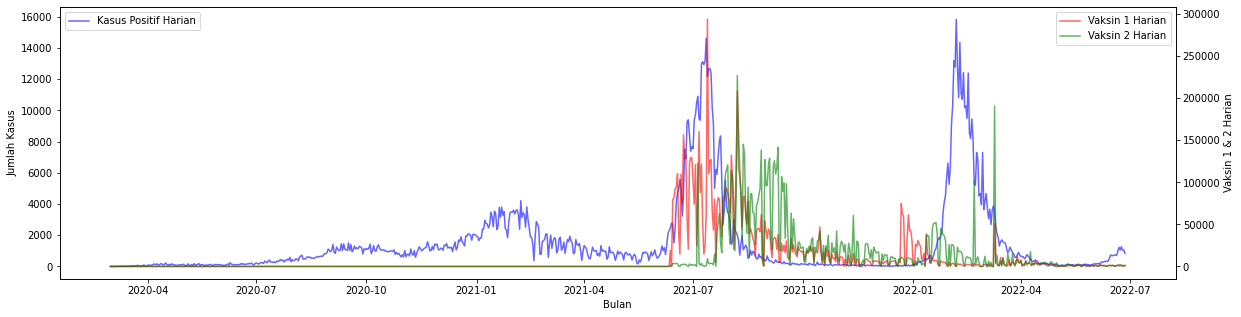

In [24]:
#Plotting daily positive case and daily vaccine data
fig, ax1 = plt.subplots()

x = agg_jkt['Tanggal']

# Plotting the same x-axis to both data
ax3 = ax2 = ax1.twinx()

# Plotting data in each of its axes
ax1.plot(x,agg_jkt['Positif Harian'],color='blue',label='Kasus Positif Harian', alpha = 0.6)
ax2.plot(x,vacc_jkt['Cakupan Suntik 1'],color='red',label='Vaksin 1 Harian', alpha = 0.6)
ax2.plot(x,vacc_jkt['Cakupan Suntik 2'],color='green',label='Vaksin 2 Harian', alpha = 0.6)

# Naming axes labels
ax1.set_xlabel('Bulan')
ax1.set_ylabel('Jumlah Kasus')
ax2.set_ylabel('Vaksin 1 & 2 Harian')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend()
ax3.legend()

# Showing the graph
plt.show()

Model grafik ini hampir mirip dengan grafik sebelumnya yaitu menunjukkan perbandingan kasus positif harian dengan data vaksin 1 dan 2. Namun memiliki perbedaan yaitu keterangan vaksinasi 1 dan 2 setiap harinya pada grafik bagian kanan.

# Conclusion



Dari awal tahun 2020 perekonomian Indonesia mengalami kontraksi pertumbuhan ekonomi pada tahun 2020 sebesar -2,07 persen. Hal ini menyebabkan perekonomian Indonesia pada tahun 2020 mengalami deflasi atau penurunan drastis karena perkembangan ekonomi di Indonesia mempunyai pegerakan yang kurang stabil. Perubahan yang terjadi dipengaruhi oleh adanya pandemi Covid-19. Mulai 9 Mei 2022 Indonesia khususnya Jakarta sedang dalam masa pemulihan ekonomi dan tempat kerja pun sudah melakukan WFO (Work From Office) karena menurunnya kasus positif covid ditandai dengan PPKM yang menurun menjadi level 1. Namun sejak memasuki musim liburan yaitu pertengahan Bulan Juni sampai waktu submisi tugas dilakukan, kasus covid 19 sudah mulai menunjukan peningkatan. Hal ini terjadi karena mulai melonggarnya kesadaran masyarakat akan pentingnya memakai masker dan melakukan vaksinasi. Solusi yang dapat kami berikan yaitu mulai ketatkan kembali pemakaian masker saat keluar rumah, segera melakukan vaksinasi, dan membatasi mobilisasi. 

# Daftar Pustaka

Biro Komunikasi. 2021. “PPKM Level Empat dan Tiga Diberlakukan Mulai 26 Juli-2 Agustus 2021”, https://maritim.go.id/ppkm-level-empat-tiga-diberlakukan-mulai-26-juli-2/, diakses pada 8 Juli 2022 pukul 14.31.

Pratiwi, Yenni Ratna. 2022. "Pemulihan Perekonomian Indonesia Setelah Kontraksi Akibat Pandemi Covid-19", https://www.djkn.kemenkeu.go.id/kpknl-banjarmasin/baca-artikel/14769/Pemulihan-Perekonomian-Indonesia-Setelah-Kontraksi-Akibat-Pandemi-Covid-19.html, diakses pada 8 Juli 2022 pukul 15.23.

Santoso, Bangun dan Stefanus Aranditio. 2022. "RESMI! Jabodetabek PPKM Level 1, Perkantoran Bisa WFO 100 Persen", https://www.suara.com/news/2022/05/24/085428/resmi-jabodetabek-ppkm-level-1-perkantoran-bisa-wfo-100-persen, diakses pada 8 Juli 2022 pukul 15.49